In [1]:
#! pip install --quiet "tabulate" "ipython[notebook]>=8.0.0, <8.12.0" "pytorch-lightning>=1.4, <2.0.0" "torchvision" "setuptools==67.4.0" "seaborn" "torch>=1.8.1, <1.14.0" "matplotlib" "torchmetrics>=0.7, <0.12" "lightning>=2.0.0rc0"
# !pip install pyheif
# !pip install albumentations

### Why CNN'S
* ANN'S are not designed to process data like Images which have spatial information because we would need to flatten them which leads to a loss of spatial information
* CNN are equivariant meaning that the resultant feature map obtained by first augmenting and then performing convolution is the same as the one obtained by first performing convolution and then performing augmentation making them invariant to spatial transformation

### How they work
* Feature extractor - this component is responsible for performing convolution on images and extracting spatial information(edges, contour, eyes, nose)
    * Convolution Layer
        * Performs the convolution operation on the image to extract spatial information utilizing
            * Kernel - filter supposed to perform convolution on images. It is first randomly initialized but later updated through back propagation to extract the spatial features more accurately. We then do element-wise product and sum of the filter matrix and the original image
            * Stride - Number of pixels by which the kernel moves while performing convolution
            * Padding - Number of pixels by which the image is padded while performing convolution sice convolution on an image leads to a reduction in the image size. So we pad to preserve the image size
            * Kernel size - This is the size of the kernel which is used to perform the convolution on Images. Using a larger kernel size leads to faster training but loss of details in the image
            * Number of filters - this is the number of convolution filters which are convoluted on the images. Each filter is stacked along the channels
        
    * Activation Function
        * introduces non-linearity in the feature maps. This is done to enhance the learning process enabling the nn to learn more complex patterns
 
    * Pooling Layer
        * Pooling is donne to reduce the number of params that gradually increase due to repeated convolutions while preserving maximum information
        * Achieved by sliding a window(usually 2* 2 window) over the resultant feature map and picks up the pooled pixel in each window
        * Variants include:
            * Max Pooling - we pick up the pixel which has the maximum value in each pixel. Throws away all other non useful info
            * Min Pooling - We pick up the pixel which has the minimum value in each pooling window
            * Average Pooling - We average all the pixels in each pooling window. Retains much info about the less important elements of a block or pool 
        
* Flattening - this component is responsible for converting the multi dimensional feature map to a 1D array which can later be processed by the classification head
* Classification Head - this component is composed of several fully connected layers which perform classification


### How do CNNs Learn
* They preserve the spatial information of the image by extracting the feature maps. By performing convolution using multiple filters the CNN learns a variety of spatial information like edges, shapes, objects e.t.c which are then flattened and passed to the classification head to predict the classes or the regression head to predict the desired quantity
    * Convolution + ReLU
    * max_pooling
    * fully_connected + ReLU
    * softmax



### Loss Functions in CNNS
* Image classification
    * Hinge Loss
    * Cross Entropy Loss
    
* Image regression:
    * MSE
    * MAE
    * Huber Loss
    
### Tricks to speed up training
* Use batch normalization
    * speeds up training
    * allows for a large learning rate
    * does not depend on weight initialization
    
* Use Global Average Pooling instead of Flatten to convert output to 1D 
    * captures the information of the feature map in each channel by taking the average
    * Reduces the number of params required to train
    * So from (channels, width, height) the average is taken along each chaneel, so the resultant shape becomes (channels, 1,1) which can be reshaped into (channels, 1) and a classification head can be attached afterwards
   

### Lets build a CNN network

In [3]:
# !pip install --upgrade numpy scipy

In [2]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
import os
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
# import pyheif

#### Setup and Data Preparation

In [11]:
n_epochs = 10
batch_size_train = 32
batch_size_test = 32
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [12]:
# path to sheep image folder
sheep_folder_path = "./IMAGES/"

In [13]:
# Define the mean and standard deviation
mean = [0.4238, 0.3821, 0.3497]
std = [0.2922, 0.2767, 0.2695]

transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.RandomRotation(58),
                               torchvision.transforms.RandomHorizontalFlip(),
#                                torchvision.transforms.RandomVerticalFlip(),
                               torchvision.transforms.Normalize(
                                 mean=mean, std=std)
                             ])

In [14]:
# create a Pytorch dataset to read the images
class CustomSheepDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root, transform)
        self.class_names = self.dataset.classes  # Get the class names
        self.class_to_idx = self.dataset.class_to_idx #map the class names to respective indices
    
    def __len__(self):
        return len(self.dataset)
        

    def __getitem__(self, idx):
        img, label = self.dataset[idx] #Get the image and label 
#         if label == self.class_to_idx['NON-SHEEP']:
#             label = 0
#         else:
#             label = 1
        
        return {'image': img, 'target': label}

In [15]:
# Create a custom dataset instance
sheep_dataset = CustomSheepDataset(root=sheep_folder_path, transform=transform)

In [16]:
# Print the class names
print("Class Names:", sheep_dataset.class_names)

Class Names: ['NON-SHEEP', 'SHEEP']


In [17]:
# check the number of images
sheep_dataset.__len__()

3795

In [81]:
sheep_dataset.__getitem__(3111)

{'image': tensor([[[-1.4504, -1.4504, -1.4504,  ..., -1.4504, -1.4504, -1.4504],
          [-1.4504, -1.4504, -1.4504,  ..., -1.4504, -1.4504, -1.4504],
          [-1.4504, -1.4504, -1.4504,  ..., -1.4504, -1.4504, -1.4504],
          ...,
          [-1.4504, -1.4504, -1.4504,  ..., -1.4504, -1.4504, -1.4504],
          [-1.4504, -1.4504, -1.4504,  ..., -1.4504, -1.4504, -1.4504],
          [-1.4504, -1.4504, -1.4504,  ..., -1.4504, -1.4504, -1.4504]],
 
         [[-1.3809, -1.3809, -1.3809,  ..., -1.3809, -1.3809, -1.3809],
          [-1.3809, -1.3809, -1.3809,  ..., -1.3809, -1.3809, -1.3809],
          [-1.3809, -1.3809, -1.3809,  ..., -1.3809, -1.3809, -1.3809],
          ...,
          [-1.3809, -1.3809, -1.3809,  ..., -1.3809, -1.3809, -1.3809],
          [-1.3809, -1.3809, -1.3809,  ..., -1.3809, -1.3809, -1.3809],
          [-1.3809, -1.3809, -1.3809,  ..., -1.3809, -1.3809, -1.3809]],
 
         [[-1.2976, -1.2976, -1.2976,  ..., -1.2976, -1.2976, -1.2976],
          [-1.2976,

In [82]:
def plot_img(img_dict):
    image_tensor = img_dict['image']
    target = img_dict['target']
    plt.figure(figsize=(5,5))
    image = image_tensor.permute(1, 2, 0)
    plt.title(target)
    plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


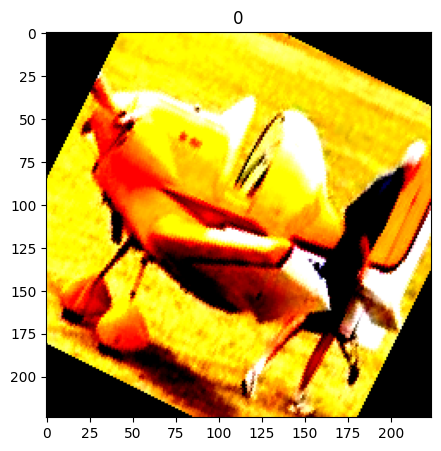

In [85]:
plot_img(sheep_dataset.__getitem__(21))

In [18]:
# Define the sizes for training, validation, and testing sets
train_size = int(0.7 * len(sheep_dataset))
val_size = int(0.15 * len(sheep_dataset))
test_size = len(sheep_dataset) - train_size - val_size

In [19]:
# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = random_split(sheep_dataset, [train_size, val_size, test_size])

In [20]:
# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [16]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([32, 3, 224, 224])

#### Building the Network

In [21]:
# Load pretrained ResNet18 model
resnet_model = torchvision.models.resnet18(pretrained=True)

In [22]:
# Freeze all layers in the ResNet model
for param in resnet_model.parameters():
    param.requires_grad = False

In [23]:
# Modify the last fully connected layer for binary classification
num_features = resnet_model.fc.in_features
num_features

512

In [24]:
resnet_model.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

#### Initialize the network and the optimizer

In [26]:
import torch.optim as optim
# network = MyCNN()
# optimizer_norm = optim.SGD(network.parameters(),lr = learning_rate, momentum = momentum)
# Define the loss function
criterion = nn.BCELoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

In [9]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
# Define training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

# Define evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_targets, all_preds)
    return accuracy

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train and evaluate the model
best_val_accuracy = 0.0
patience = 3
early_stopping_counter = 0

for epoch in range(1, n_epochs + 1):
    train_loss = train(resnet_model, train_loader, optimizer, criterion, device)
    val_accuracy = evaluate(resnet_model, val_loader, device)
    print(f'Epoch [{epoch}/{n_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        early_stopping_counter = 0
        torch.save(resnet_model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/10], Train Loss: 0.0739, Validation Accuracy: 0.9930
Epoch [2/10], Train Loss: 0.0590, Validation Accuracy: 0.9877
Epoch [3/10], Train Loss: 0.0515, Validation Accuracy: 0.9877
Epoch [4/10], Train Loss: 0.0693, Validation Accuracy: 0.9947
Epoch [5/10], Train Loss: 0.0323, Validation Accuracy: 0.9947
Epoch [6/10], Train Loss: 0.0477, Validation Accuracy: 0.9842
Epoch [7/10], Train Loss: 0.0316, Validation Accuracy: 0.9930
Early stopping triggered.


In [28]:
# Load the best model
resnet_model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on the test set
test_accuracy = evaluate(resnet_model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9895


In [29]:
# Load the saved model weights
resnet_model.load_state_dict(torch.load('best_model.pth'))
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# Define the transforms for preprocessing the input images
transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.RandomRotation(58),
                               torchvision.transforms.RandomHorizontalFlip(),
#                                torchvision.transforms.RandomVerticalFlip(),
                               torchvision.transforms.Normalize(
                                 mean=mean, std=std)
                             ])

# Function to predict the class of an image
def predict_image(image_path, model, transform, device):
    # Open the image
    image = Image.open(image_path)
    # Preprocess the image
    input_tensor = transform(image)
    # Add a batch dimension
    input_tensor = input_tensor.unsqueeze(0).to(device)
    # Perform prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = 'Sheep' if output.item() > 0.8 else 'Non-Sheep'
    return predicted_class

# Example usage
image_path = './image_2caf.jpg'
predicted_class = predict_image(image_path, resnet_model, transform, device)
print('Predicted class:', predicted_class)

Predicted class: Non-Sheep


In [31]:
!pip install boto3

In [33]:
import boto3

In [35]:
s3 = boto3.resource(
    service_name = 's3',
    region_name='',
    aws_acces_key_id='',
    aws_secret_access_key=''

)

In [36]:
!pip install s3fs

  Obtaining dependency information for botocore<1.29.77,>=1.29.76 from https://files.pythonhosted.org/packages/87/93/e862d4b2ec9b0c8f7a6ee3141df138c00aa91de42839e55b68e3ebb53bf2/botocore-1.29.76-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.4 MB 165.2 kB/s eta 0:01:03
   ---------------------------------------- 0.0/10.4 MB 219.4 kB/s eta 0:00:48
   ---------------------------------------- 0.1/10.4 MB 357.2 kB/s eta 0:00:29
    --------------------------------------- 0.2/10.4 MB 700.2 kB/s eta 0:00:15
   - -------------------------------------- 0.3/10.4 MB 911.0 kB/s eta 0:00:12
   - -------------------------------------- 0.3/10.4 MB 1.0 MB/s eta 0:00:10
   - -------------------------------------- 0.3/10.4 MB 1.0 MB/s eta 0:00:10
   -- ------------------------------------- 0.7/10.4 MB 1.5 MB/s eta 0:00:07
   -- -------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.34.90 requires botocore<1.35.0,>=1.34.90, but you have botocore 1.29.76 which is incompatible.
s3transfer 0.10.1 requires botocore<2.0a.0,>=1.33.2, but you have botocore 1.29.76 which is incompatible.
